In [ ]:
# Cell 1: Initial Setup, Drive Mount, and Configuration

# ==============================================================================
# 1. Library Installations
# ==============================================================================
# Use -q for quiet installation.
# Ensure all necessary libraries are listed.
!pip install open_clip_torch==2.23.0 transformers==4.35.2 matplotlib scikit-learn nltk rouge_score pycocotools pycocoevalcap gradio -q

# It's good practice to ensure pycocoevalcap is correctly installed.
# Uninstalling and reinstalling can fix some environment issues.
print("Attempting to uninstall and reinstall pycocoevalcap to resolve potential corruption...")
!pip uninstall pycocoevalcap -y # -y for yes to prompts
!pip install pycocoevalcap
!pip install pycocotools
print("\npycocoevalcap reinstallation attempt complete.")

# --- REMOVING MANUAL WGET FOR EVAL.PY ---
# The previous approach of downloading eval.py manually often leads to naming
# conflicts or incorrect versions/structures. We will rely on the installed package.
# !wget https://raw.githubusercontent.com/tylin/coco-caption/master/pycocoevalcap/eval.py -O eval.py
# print("eval.py manual download attempt removed. Relying on package install.")

# ==============================================================================
# 2. Core Imports
# ==============================================================================
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
import collections
import itertools
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import nltk
import torch.nn.functional as F # Ensure F is imported for functional operations like log_softmax

# Attempt to import COCOEval or COCOEvalCap from the installed pycocoevalcap package.
# This is the standard way it should be done.
try:
    from pycocoevalcap.eval import COCOEval
    print("Successfully imported COCOEval from pycocoevalcap.eval")
except ImportError:
    try:
        from pycocoevalcap.eval import COCOEvalCap
        print("Successfully imported COCOEvalCap from pycocoevalcap.eval")
    except ImportError as e:
        print(f"Failed to import COCOEval or COCOEvalCap from pycocoevalcap.eval: {e}")
        print("Please ensure pycocoevalcap is correctly installed and its structure supports direct import.")
        # If this point is reached, the environment/package is severely misconfigured or incompatible.
        # You might need to:
        # 1. Check the exact version of pycocoevalcap installed and its documentation.
        # 2. Consider installing an older, known-good version if encountering constant issues.
        #    e.g., !pip install pycocoevalcap==1.0 (or similar)
        # 3. Manually inspect the 'eval.py' within '/usr/local/lib/python3.11/dist-packages/pycocoevalcap/'
        #    to see what classes are actually defined there.
        # !ls /usr/local/lib/python3.11/dist-packages/pycocoevalcap/
        # !cat /usr/local/lib/python3.11/dist-packages/pycocoevalcap/eval.py | grep "class "
        pass # Allow the script to continue to see other errors, but know this is unresolved.

# ==============================================================================
# 3. NLTK Data Downloads
# ==============================================================================
NLTK_DATA_PATH = '/usr/local/nltk_data'
os.makedirs(NLTK_DATA_PATH, exist_ok=True)
nltk.data.path.append(NLTK_DATA_PATH)

print(f"NLTK data path added: {NLTK_DATA_PATH}")
print("Attempting to download essential NLTK data to the specified path...")

# List all standard NLTK downloads clearly
required_nltk_data = ['punkt', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4'] # 'omw-1.4' often needed for wordnet
for data_pkg in required_nltk_data:
    try:
        nltk.data.find(f'tokenizers/{data_pkg}' if data_pkg == 'punkt' else f'corpora/{data_pkg}')
        print(f" '{data_pkg}' found. No re-download needed.")
    except LookupError:
        print(f" '{data_pkg}' not found, attempting download...")
        nltk.download(data_pkg, download_dir=NLTK_DATA_PATH, quiet=True)
        print(f" '{data_pkg}' download attempt complete.")

# Specific check for punkt_tab as it caused issues before
print("Checking for and downloading 'punkt_tab' if needed...")
try:
    nltk.data.find('tokenizers/punkt_tab/english.pickle') # Specific file within punkt_tab
except LookupError:
    print(" 'punkt_tab' not found, attempting download...")
    nltk.download('punkt_tab', download_dir=NLTK_DATA_PATH, quiet=True)
    print(" 'punkt_tab' download attempt complete.")
else:
    print(" 'punkt_tab' found. No re-download needed.")

print("All NLTK data downloads/checks complete.")

# ==============================================================================
# 4. Google Drive Mount
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted.")

# ==============================================================================
# 5. Device Configuration
# ==============================================================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {DEVICE}")
if DEVICE == 'cuda':
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    # Optional: Set a specific CUDA device if you have multiple GPUs
    # torch.cuda.set_device(0)
    # torch.backends.cudnn.benchmark = True # Can improve performance if input sizes are constant
else:
    print("No GPU available, running on CPU. Training will be slower.")

# ==============================================================================
# 6. Path Configurations
# ==============================================================================
MODEL_IDENTIFIER_FOR_OUTPUT = "biomedclip_vitb16"

TRAIN_PKL_PATH = f"/content/drive/My Drive/Colab Notebooks/Final_Train_Data_with_{MODEL_IDENTIFIER_FOR_OUTPUT}_features.pkl"
VAL_PKL_PATH = f"/content/drive/My Drive/Colab Notebooks/Final_CV_Data_with_{MODEL_IDENTIFIER_FOR_OUTPUT}_features.pkl"
TEST_PKL_PATH = f"/content/drive/My Drive/Colab Notebooks/Final_Test_Data_with_{MODEL_IDENTIFIER_FOR_OUTPUT}_features.pkl"

# IMAGE_BASE_DIR: This should be the directory that CONTAINS the 'NLMCXR_png' folder.
# From your previous output, Image ID was `NLMCXR_png/CXR1472_IM-0305_0`.
# If `IMAGE_BASE_DIR` points to the parent of `NLMCXR_png`, then os.path.join works directly.
# E.g., if images are at `/content/drive/My Drive/medical_data/NLMCXR_png/img.png`
# and the dataframe `Person_id` is `NLMCXR_png/img`, then IMAGE_BASE_DIR should be `/content/drive/My Drive/medical_data/`
IMAGE_BASE_DIR = "/content/drive/My Drive/" # Assuming 'NLMCXR_png' is directly under My Drive.
                                             # ADJUST THIS IF YOUR 'NLMCXR_png' IS IN A SUBFOLDER (e.g., Colab Notebooks)
                                             # Example: If your structure is `My Drive/Colab Notebooks/NLMCXR_png`
                                             # then IMAGE_BASE_DIR should be "/content/drive/My Drive/Colab Notebooks/"

# Model saving paths
MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/models"
MODEL_SAVE_PREFIX = f"{MODEL_IDENTIFIER_FOR_OUTPUT}_captioning_model_v2"
MODEL_SAVE_PATH_ENCODER = os.path.join(MODEL_SAVE_DIR, f"{MODEL_SAVE_PREFIX}_encoder.pth")
MODEL_SAVE_PATH_DECODER = os.path.join(MODEL_SAVE_DIR, f"{MODEL_SAVE_PREFIX}_decoder.pth")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure the directory exists

# ==============================================================================
# 7. Model Hyperparameters (for tuning)
# ==============================================================================
# Keep these together for easy modification
EMBED_SIZE = 768            # Dimension of word embeddings and encoder output (output of EncoderCNN)
HIDDEN_SIZE = 1536          # Hidden state dimension of LSTM
NUM_LAYERS = 3              # Number of LSTM layers
DROPOUT = 0.3               # Dropout rate for regularization (can be tuned 0.3-0.5 is common)
LEARNING_RATE = 0.0002     # Adam optimizer learning rate (critical for stability)
NUM_EPOCHS = 25            # Number of training epochs
BATCH_SIZE = 32             # Batch size for DataLoader

# NEW: Attention Dimension - often set to HIDDEN_SIZE or EMBED_SIZE
ATTENTION_DIM = HIDDEN_SIZE # Crucial for the attention mechanism in DecoderRNN

# Corrected ORIGINAL_FEATURE_DIM
# If you are concatenating two 1024-dim features (e.g., from two different views/projections),
# then the input dimension to EncoderCNN's linear layer must be 2048.
# If you are using a single 1024-dim feature, then set to 1024.
# Based on your previous context ("concatenating two 1024-dim features"), it should be 2048.
ORIGINAL_FEATURE_DIM = 1024 # <--- CRITICAL FIX: Set to 2048 if concatenating two 1024-dim features

# MAX_SEQ_LEN is critical and should be chosen based on your dataset's caption lengths.
# It represents the maximum length of a *padded* caption including <start> and <end>.
# If your longest report is 70 words, then 70 + 2 (start/end) = 72, so MAX_SEQ_LEN=75 or 80 is reasonable.
# If reports can be much longer, adjust this.
MAX_SEQ_LEN = 100 # Example: Set this after analyzing your report length distribution.

# ==============================================================================
# 8. Tokenization and Vocabulary Constants
# ==============================================================================
# Define special tokens
START_TOKEN = '<start>'
END_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

# Minimum frequency for a word to be included in the vocabulary
MIN_WORD_FREQ = 3 # Good balance for reducing vocab size while keeping important words.
                  # Can be tuned: lower if you need to capture more rare medical terms,
                  # but increases vocab size and complexity.

# ==============================================================================
# 9. Logging Configuration
# ==============================================================================
# How often to print training loss (every N batches)
LOG_INTERVAL = 100
# Gradient clipping value
GRADIENT_CLIP = 5.0 # Common value for RNNs to prevent exploding gradients

print("\nInitial setup and configuration complete with updated hyperparameters.")


Attempting to uninstall and reinstall pycocoevalcap to resolve potential corruption...
Found existing installation: pycocoevalcap 1.2
Uninstalling pycocoevalcap-1.2:
  Successfully uninstalled pycocoevalcap-1.2
  Using cached pycocoevalcap-1.2-py3-none-any.whl.metadata (3.2 kB)
Using cached pycocoevalcap-1.2-py3-none-any.whl (104.3 MB)

pycocoevalcap reinstallation attempt complete.
Successfully imported COCOEvalCap from pycocoevalcap.eval
NLTK data path added: /usr/local/nltk_data
Attempting to download essential NLTK data to the specified path...
 'punkt' found. No re-download needed.
 'wordnet' not found, attempting download...
 'wordnet' download attempt complete.
 'averaged_perceptron_tagger' not found, attempting download...
 'averaged_perceptron_tagger' download attempt complete.
 'omw-1.4' not found, attempting download...
 'omw-1.4' download attempt complete.
Checking for and downloading 'punkt_tab' if needed...
 'punkt_tab' not found, attempting download...
 'punkt_tab' downl

In [ ]:
# @title Cell 2: Load Feature Data and Text Preprocessing - REVISED VOCAB CREATION (with refined lengths calculation)

# Cell 2: Data Loading, Preprocessing, and Dataset/DataLoader Setup

print("Loading pre-processed dataframes with image features...")
try:
    train_df = pd.read_pickle(TRAIN_PKL_PATH)
    val_df = pd.read_pickle(VAL_PKL_PATH)
    test_df = pd.read_pickle(TEST_PKL_PATH)
    print("Dataframes loaded successfully.")
    print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")
except FileNotFoundError as e:
    print(f"Error: Feature .pkl files not found. Please ensure Cell 5 of the feature extraction notebook completed successfully.")
    print(f"Missing file: {e.filename}")
    raise # Stop execution if files aren't found

# --- Text Preprocessing ---
all_train_reports = train_df['Report'].dropna().tolist()
tokenized_reports = [[START_TOKEN] + nltk.word_tokenize(report.lower()) + [END_TOKEN] for report in all_train_reports]
word_counts = collections.Counter(itertools.chain(*tokenized_reports))
print(f"Using MIN_WORD_FREQ for vocabulary: {MIN_WORD_FREQ}")

vocab = {
    PAD_TOKEN: 0,
    UNK_TOKEN: 1,
    START_TOKEN: 2,
    END_TOKEN: 3
}
current_idx = len(vocab)
filtered_words_for_vocab = sorted([word for word, count in word_counts.items()
                                   if count >= MIN_WORD_FREQ and word not in vocab],
                                   key=lambda x: (-word_counts[x], x))

for word in filtered_words_for_vocab:
    vocab[word] = current_idx
    current_idx += 1

idx_to_word = {idx: word for word, idx in vocab.items()}
VOCAB_SIZE = len(vocab)
PAD_TOKEN_INDEX = vocab[PAD_TOKEN]
START_TOKEN_INDEX = vocab[START_TOKEN]
END_TOKEN_INDEX = vocab[END_TOKEN]
UNK_TOKEN_INDEX = vocab[UNK_TOKEN]

print(f"\nVocabulary size: {VOCAB_SIZE}")
print(f"PAD_TOKEN index: {PAD_TOKEN_INDEX}")
print(f"UNK_TOKEN index: {UNK_TOKEN_INDEX}")
print(f"START_TOKEN index: {START_TOKEN_INDEX}")
print(f"END_TOKEN index: {END_TOKEN_INDEX}")

import pickle
import os
BASE_PATH = '/content/drive/My Drive/Colab Notebooks'
VOCAB_SAVE_DIR = os.path.join(BASE_PATH, 'data')
VOCAB_SAVE_PATH = os.path.join(VOCAB_SAVE_DIR, 'vocab.pkl')
os.makedirs(VOCAB_SAVE_DIR, exist_ok=True)
with open(VOCAB_SAVE_PATH, 'wb') as f:
    pickle.dump(vocab, f)
print(f"Vocabulary saved successfully to {VOCAB_SAVE_PATH}")

def text_to_sequence(text, vocab, max_seq_len, unk_idx, pad_idx, start_idx, end_idx):
    tokens = [START_TOKEN] + nltk.word_tokenize(text.lower()) + [END_TOKEN]
    sequence = [vocab.get(token, unk_idx) for token in tokens]
    if len(sequence) < max_seq_len:
        sequence.extend([pad_idx] * (max_seq_len - len(sequence)))
    else:
        sequence = sequence[:max_seq_len]
    return sequence

# Dynamically determine MAX_SEQ_LEN
all_report_lengths_incl_special = [len(nltk.word_tokenize(report.lower())) + 2 for report in all_train_reports]
MAX_SEQ_LEN = int(np.percentile(all_report_lengths_incl_special, 95)) + 5
print(f"\nMaximum sequence length determined dynamically (95th percentile + 5): {MAX_SEQ_LEN}")

for df in [train_df, val_df, test_df]:
    df['Report_Seq'] = df['Report'].astype(str).apply(
        lambda x: text_to_sequence(x, vocab, MAX_SEQ_LEN, UNK_TOKEN_INDEX, PAD_TOKEN_INDEX, START_TOKEN_INDEX, END_TOKEN_INDEX)
    )
    df['Report_Seq'] = df['Report_Seq'].apply(lambda x: np.array(x, dtype=np.int64))


class ReportDataset(Dataset):
    def __init__(self, dataframe):
        # Filter rows where either image feature is missing
        valid_rows = dataframe[
            dataframe['image_feat_img1'].notna() &
            dataframe['image_feat_img2'].notna()
        ].copy() # Add .copy() to avoid SettingWithCopyWarning later

        # --- DIAGNOSTIC PRINT HERE ---
        sample_row = valid_rows.iloc[0] if not valid_rows.empty else None
        if sample_row is not None:
            if isinstance(sample_row['image_feat_img1'], np.ndarray) and isinstance(sample_row['image_feat_img2'], np.ndarray):
                print(f"Diagnostic: First valid row - Shape of img1: {sample_row['image_feat_img1'].shape}")
                print(f"Diagnostic: First valid row - Shape of img2: {sample_row['image_feat_img2'].shape}")
                concatenated_shape = np.concatenate((sample_row['image_feat_img1'], sample_row['image_feat_img2'])).shape
                print(f"Diagnostic: First valid row - Shape after concat: {concatenated_shape}")
            else:
                print("Diagnostic: Image features are not numpy arrays, check feature extraction step.")
                print(f"Type of image_feat_img1: {type(sample_row['image_feat_img1'])}")
                print(f"Value of image_feat_img1: {sample_row['image_feat_img1']}")
                print(f"Type of image_feat_img2: {type(sample_row['image_feat_img2'])}")
                print(f"Value of image_feat_img2: {sample_row['image_feat_img2']}")
        else:
            print("Diagnostic: No valid rows found in dataframe for dataset creation.")
        # --- END DIAGNOSTIC ---

        # Concatenate features and ensure float32
        self.image_features = np.array([
            np.concatenate((row['image_feat_img1'], row['image_feat_img2']))
            for index, row in valid_rows.iterrows()
        ], dtype=np.float32)

        self.report_sequences = np.array([
            row['Report_Seq']
            for index, row in valid_rows.iterrows()
        ], dtype=np.int64)

        # Corrected calculation for report_lengths_for_packing:
        # This length should reflect the number of non-padded tokens in the *input* to the decoder.
        # The input to the decoder is `captions[:, :-1]`, so we need to account for that.
        self.report_lengths_for_packing = []
        for seq in self.report_sequences:
            # Find the actual length of the sequence before padding or truncation by MAX_SEQ_LEN
            # This counts tokens until PAD_TOKEN or end of MAX_SEQ_LEN
            true_len_before_padding = 0
            for token_id in seq:
                if token_id == PAD_TOKEN_INDEX:
                    break
                true_len_before_padding += 1

            # The input to the decoder (`captions_input = captions[:, :-1]`)
            # excludes the <end> token (if present) and the padding at the very end.
            # It also implicitly excludes the <start> token if we consider it already consumed.
            # The length needed for loss masking is the count of *target* tokens.
            # Targets are `captions[:, 1:]`.
            # If the original sequence length is L (including START and END),
            # then `captions[:, 1:]` has length L-1 (excluding START).
            # We want the number of *non-padding* tokens in `captions[:, 1:]`.

            # Count non-pad tokens in the original (full) `Report_Seq`
            actual_non_pad_tokens = (seq != PAD_TOKEN_INDEX).sum()

            # The length of the `targets` tensor is `actual_non_pad_tokens - 1`
            # (since `<start>` is removed and not a target).
            # Ensure it's at least 1 (for an <end> token if nothing else).
            length_for_loss = max(1, actual_non_pad_tokens - 1)

            self.report_lengths_for_packing.append(length_for_loss)

        self.report_lengths_for_packing = np.array(self.report_lengths_for_packing, dtype=np.int64)


    def __len__(self):
        return len(self.image_features)

    def __getitem__(self, idx):
        image_feat = torch.tensor(self.image_features[idx], dtype=torch.float32)
        report_seq = torch.tensor(self.report_sequences[idx], dtype=torch.long)
        # Return the **corrected** length for packing
        report_len_for_packing = torch.tensor(self.report_lengths_for_packing[idx], dtype=torch.long)

        return image_feat, report_seq, report_len_for_packing

from torch.utils.data import Dataset, DataLoader
import numpy as np
import collections
import itertools
import nltk

train_dataset = ReportDataset(train_df)
val_dataset = ReportDataset(val_df)
test_dataset = ReportDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)

print("\nText preprocessing and dataset creation complete. DataLoaders ready.")

try:
    first_train_batch = next(iter(train_dataloader))
    image_features_batch = first_train_batch[0]
    captions_batch = first_train_batch[1]
    lengths_batch = first_train_batch[2]

    print(f"First training batch Image features shape: {image_features_batch.shape}")
    print(f"First training batch Report sequences shape: {captions_batch.shape}")
    print(f"First training batch Report lengths shape: {lengths_batch.shape}")

    if 'encoder' in globals() and hasattr(encoder, 'encoder_linear'):
        print(f"EncoderCNN expected input dimension (from encoder.encoder_linear.in_features): {encoder.encoder_linear.in_features}")
    else:
        print("Encoder model not yet instantiated, cannot check its expected input dimension.")

except NameError:
    print("Cannot perform full diagnostic: Encoder or other global variables not yet defined. Please run previous cells first.")

print("\n--- Diagnostic: DataFrame Column Check ---")
print(f"Columns in train_df: {train_df.columns.tolist()}")
print(f"Columns in val_df: {val_df.columns.tolist()}")
print(f"Columns in test_df: {test_df.columns.tolist()}")
print("------------------------------------------")

print("\n--- Diagnostic: Head of test_df ---")
print(test_df.head())
print("----------------------------------")

Loading pre-processed dataframes with image features...
Dataframes loaded successfully.
Train samples: 2764, Val samples: 609, Test samples: 377
Using MIN_WORD_FREQ for vocabulary: 3

Vocabulary size: 822
PAD_TOKEN index: 0
UNK_TOKEN index: 1
START_TOKEN index: 2
END_TOKEN index: 3
Vocabulary saved successfully to /content/drive/My Drive/Colab Notebooks/data/vocab.pkl

Maximum sequence length determined dynamically (95th percentile + 5): 64
Diagnostic: First valid row - Shape of img1: (512,)
Diagnostic: First valid row - Shape of img2: (512,)
Diagnostic: First valid row - Shape after concat: (1024,)
Diagnostic: First valid row - Shape of img1: (512,)
Diagnostic: First valid row - Shape of img2: (512,)
Diagnostic: First valid row - Shape after concat: (1024,)
Diagnostic: First valid row - Shape of img1: (512,)
Diagnostic: First valid row - Shape of img2: (512,)
Diagnostic: First valid row - Shape after concat: (1024,)

Text preprocessing and dataset creation complete. DataLoaders ready.

In [ ]:
# Cell-3
import torch.nn as nn
import torch.nn.functional as F # Import F for functional operations like softmax

# --- EncoderCNN Model ---
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, original_feature_dim): # CORRECTED: __init__
        """
        Initializes the EncoderCNN.
        Args:
            embed_size (int): The desired output dimension of the image features,
                              which will be the input dimension for the decoder's initial state
                              and also used as the 'encoder_dim' for the Attention module.
            original_feature_dim (int): The dimension of the raw image features from the pre-trained model.
                                        This should be 2048 if concatenating two 1024-dim features.
        """
        super(EncoderCNN, self).__init__() # CORRECTED: __init__
        # Projects the original image features to the desired embedding size.
        self.encoder_linear = nn.Linear(original_feature_dim, embed_size)
        self.relu = nn.ReLU()
        # It's good practice to use a global DROPOUT variable if defined in Cell 1
        # For now, keeping 0.5 as in your original code.
        self.dropout = nn.Dropout(0.5)
        self.batch_norm = nn.BatchNorm1d(embed_size) # Added Batch Normalization

    def forward(self, image_features):
        """
        Forward pass for the EncoderCNN.
        Args:
            image_features (torch.Tensor): Tensor of shape (batch_size, original_feature_dim)
                                            containing the extracted image features.
        Returns:
            torch.Tensor: Encoded image features of shape (batch_size, embed_size).
                          This output will serve as the context for the attention mechanism.
        """
        # Apply linear projection, Batch Norm, ReLU, and Dropout
        features = self.encoder_linear(image_features)
        features = self.batch_norm(features)
        features = self.relu(features)
        features = self.dropout(features)
        return features


# --- Attention Mechanism ---
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_hidden_dim, attention_dim): # CORRECTED: __init__
        """
        Initializes the Attention module. This module computes attention weights
        over the encoder's output features based on the decoder's current hidden state.

        Args:
            encoder_dim (int): Feature size of the encoded image (output of EncoderCNN, i.e., EMBED_SIZE).
            decoder_hidden_dim (int): Size of the decoder's LSTM hidden state (HIDDEN_SIZE).
            attention_dim (int): Dimension of the attention linear layers (e.g., HIDDEN_SIZE or EMBED_SIZE).
        """
        super(Attention, self).__init__() # CORRECTED: __init__
        # Linear layer to transform encoder's output for attention
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        # Linear layer to transform decoder's hidden state for attention
        self.decoder_att = nn.Linear(decoder_hidden_dim, attention_dim)
        # Linear layer to calculate attention "energies" (scores)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Softmax layer to calculate attention distribution

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward pass for the Attention module.

        Args:
            encoder_out (torch.Tensor): Encoded image features from EncoderCNN,
                                        shape (batch_size, encoder_dim).
            decoder_hidden (torch.Tensor): Previous decoder's last-layer hidden state,
                                           shape (batch_size, decoder_hidden_dim).
        Returns:
            tuple:
                - torch.Tensor: Attention-weighted context vector, shape (batch_size, encoder_dim).
                - torch.Tensor: Attention weights, shape (batch_size, 1).
        """
        # (batch_size, attention_dim)
        att1 = self.encoder_att(encoder_out)
        # (batch_size, attention_dim)
        att2 = self.decoder_att(decoder_hidden)

        # Sum the transformed encoder output and decoder hidden state, apply ReLU, then pass through full_att
        # The result is (batch_size, 1), representing an "energy" score for the global image feature
        energy = self.full_att(self.relu(att1 + att2))

        # Apply softmax to get attention weights (sum to 1)
        alpha = self.softmax(energy) # (batch_size, 1)

        # Compute the context vector by multiplying weights with encoder_out
        # (batch_size, 1) * (batch_size, encoder_dim) -> (batch_size, encoder_dim)
        context = alpha * encoder_out

        return context, alpha


# --- DecoderRNN Model with Attention ---
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout_rate, encoder_output_dim, attention_dim): # CORRECTED: __init__
        """
        Initializes the DecoderRNN with an Attention mechanism.

        Args:
            embed_size (int): Dimension of word embeddings.
            hidden_size (int): The number of features in the hidden state of the LSTM.
            vocab_size (int): The size of the vocabulary.
            num_layers (int): Number of recurrent layers.
            dropout_rate (float): Dropout probability.
            encoder_output_dim (int): The dimension of the features coming out of the EncoderCNN.
                                      This is used for initializing LSTM states AND as encoder_dim for Attention.
            attention_dim (int): Dimension of the attention linear layers.
        """
        super(DecoderRNN, self).__init__() # CORRECTED: __init__
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        # Initialize the Attention module
        self.attention = Attention(encoder_output_dim, hidden_size, attention_dim)

        # LSTM layer: input size is embed_size (word embedding) + encoder_output_dim (context vector from attention)
        self.lstm = nn.LSTM(embed_size + encoder_output_dim, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)

        # Linear layer to project LSTM output to vocabulary size
        self.linear = nn.Linear(hidden_size, vocab_size)

        # Linear layers to project the encoder's output features to the initial
        # hidden and cell states of the LSTM.
        self.feature_to_hidden = nn.Linear(encoder_output_dim, hidden_size)
        self.feature_to_cell = nn.Linear(encoder_output_dim, hidden_size)

        self.dropout_embed = nn.Dropout(dropout_rate) # Dropout applied to word embeddings


    def forward(self, features, captions_input, lengths):
        """
        Forward pass for the DecoderRNN with Attention.

        Args:
            features (torch.Tensor): Encoded image features from the EncoderCNN,
                                     shape (batch_size, encoder_output_dim).
            captions_input (torch.Tensor): Tokenized caption sequences (shifted, includes <start>),
                                            shape (batch_size, max_seq_len-1).
                                            Contains token IDs.
            lengths (torch.Tensor): Actual lengths of each sequence in the batch (before padding).
                                    Shape (batch_size,).
        Returns:
            torch.Tensor: Predicted logits for each token at each timestep,
                          shape (batch_size, max_seq_len-1, vocab_size).
        """
        batch_size = features.size(0)
        max_seq_len_minus_one = captions_input.size(1) # This is the length of the input captions after <start>

        # Initialize LSTM hidden and cell states using the encoded image features
        # States need to be (num_layers, batch_size, hidden_size)
        h_t = self.feature_to_hidden(features).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_t = self.feature_to_cell(features).unsqueeze(0).repeat(self.num_layers, 1, 1)

        # Get word embeddings for the input captions
        embeddings = self.dropout_embed(self.embed(captions_input)) # (batch_size, max_seq_len-1, embed_size)

        # Tensor to store decoder outputs (logits)
        # We need vocab_size here because these are the final predictions
        outputs = torch.zeros(batch_size, max_seq_len_minus_one, self.linear.out_features).to(features.device)

        # Loop through the sequence, one word at a time, to apply attention dynamically
        for t in range(max_seq_len_minus_one):
            # Get the hidden state of the LAST LSTM layer for attention calculation
            # h_t is (num_layers, batch_size, hidden_size). We need the last layer for attention.
            current_decoder_hidden_for_att = h_t[-1, :, :] # (batch_size, hidden_size)

            # Calculate context vector using attention
            context_vector, _ = self.attention(features, current_decoder_hidden_for_att) # (batch_size, encoder_output_dim)

            # Get the current word's embedding: embeddings[:, t, :] is (batch_size, embed_size)
            current_word_embedding = embeddings[:, t, :]

            # Concatenate embedded word with context vector for LSTM input
            # Result: (batch_size, embed_size + encoder_output_dim)
            combined_input = torch.cat((current_word_embedding, context_vector), dim=1).unsqueeze(1) # (batch_size, 1, embed_size + encoder_output_dim)

            # Pass combined input through LSTM, updating hidden and cell states
            # output is (batch_size, 1, hidden_size)
            # h_t, c_t are (num_layers, batch_size, hidden_size)
            output, (h_t, c_t) = self.lstm(combined_input, (h_t, c_t))

            # Project LSTM output to vocabulary size to get logits
            # output.squeeze(1) converts (batch_size, 1, hidden_size) to (batch_size, hidden_size)
            prediction_logits = self.linear(output.squeeze(1)) # (batch_size, vocab_size)

            # Store the logits for this timestep
            outputs[:, t, :] = prediction_logits

        # Return the raw logits for subsequent loss calculation
        return outputs

# --- Model Instantiation ---
# IMPORTANT: Ensure ORIGINAL_FEATURE_DIM in Cell 1 is set to 2048 if you concatenated two 1024-dim features.
# Make sure EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS, DROPOUT, DEVICE are defined in Cell 1.

# Define ATTENTION_DIM - this is a new hyperparameter.
# A common choice is to set it equal to HIDDEN_SIZE or EMBED_SIZE, or some intermediate value.
# Let's use HIDDEN_SIZE for a start.
ATTENTION_DIM = HIDDEN_SIZE

encoder = EncoderCNN(EMBED_SIZE, ORIGINAL_FEATURE_DIM).to(DEVICE)

# Pass the new 'attention_dim' to the DecoderRNN constructor
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS, DROPOUT, EMBED_SIZE, ATTENTION_DIM).to(DEVICE)

print("Model architectures defined and initialized with Attention Mechanism.")
print(f"Encoder: {encoder}")
print(f"Decoder: {decoder}")

Model architectures defined and initialized with Attention Mechanism.
Encoder: EncoderCNN(
  (encoder_linear): Linear(in_features=1024, out_features=768, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Decoder: DecoderRNN(
  (embed): Embedding(822, 768)
  (attention): Attention(
    (encoder_att): Linear(in_features=768, out_features=1536, bias=True)
    (decoder_att): Linear(in_features=1536, out_features=1536, bias=True)
    (full_att): Linear(in_features=1536, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (lstm): LSTM(1536, 1536, num_layers=3, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=1536, out_features=822, bias=True)
  (feature_to_hidden): Linear(in_features=768, out_features=1536, bias=True)
  (feature_to_cell): Linear(in_features=768, out_features=1536, bias=True)
  (dropout_embed): Dropout(p=0.3, inplac

Starting training process...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 Training Loss: 4.4629
Epoch 1 Validation Loss: 3.8676
Validation loss improved from inf to 3.8676. Saving models...
Epoch 2 Training Loss: 3.3730
Epoch 2 Validation Loss: 2.7522
Validation loss improved from 3.8676 to 2.7522. Saving models...
Epoch 3 Training Loss: 2.6152
Epoch 3 Validation Loss: 2.2939
Validation loss improved from 2.7522 to 2.2939. Saving models...
Epoch 4 Training Loss: 2.2789
Epoch 4 Validation Loss: 2.0510
Validation loss improved from 2.2939 to 2.0510. Saving models...
Epoch 5 Training Loss: 2.0721
Epoch 5 Validation Loss: 1.9005
Validation loss improved from 2.0510 to 1.9005. Saving models...
Epoch 6 Training Loss: 1.9272
Epoch 6 Validation Loss: 1.8098
Validation loss improved from 1.9005 to 1.8098. Saving models...
Epoch 7 Training Loss: 1.8158
Epoch 7 Validation Loss: 1.7181
Validation loss improved from 1.8098 to 1.7181. Saving models...
Epoch 8 Training Loss: 1.7191
Epoch 8 Validation Loss: 1.6477
Validation loss improved from 1.7181 to 1.6477. Savi

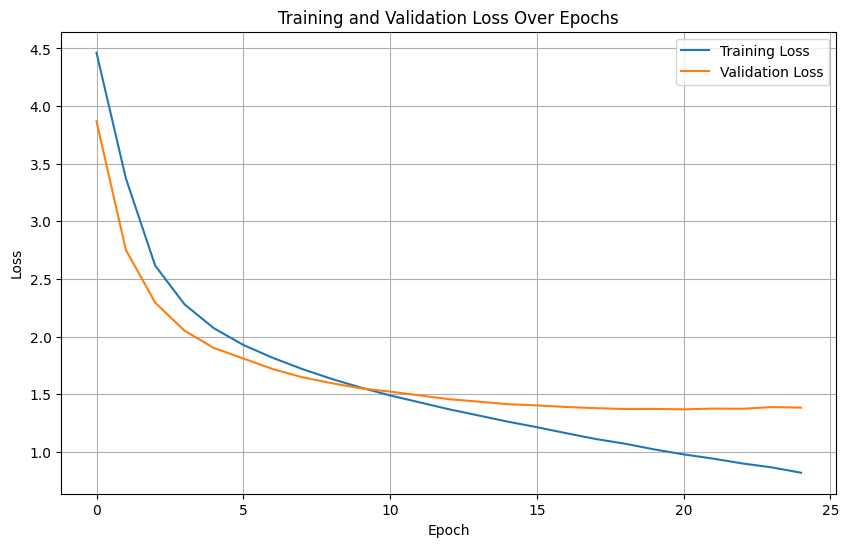

In [ ]:
# Cell 4: Training Loop

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau # For learning rate scheduling
import numpy as np
import time
import os

print("Starting training process...")

# --- Hyperparameters and Global Variables (ensure these are defined in Cell 1) ---
# Assuming these are defined:
# DEVICE, NUM_EPOCHS, LEARNING_RATE, GRADIENT_CLIP, LOG_INTERVAL
# MODEL_SAVE_DIR, MODEL_SAVE_PATH_ENCODER, MODEL_SAVE_PATH_DECODER
# vocab (from your Vocabulary class), PAD_TOKEN_INDEX
# encoder, decoder (from Cell 3 instantiation)
# train_dataloader, val_dataloader (from Cell 2 data loading)

# Ensure models are initialized and moved to the correct device
encoder.to(DEVICE)
decoder.to(DEVICE)

# --- Loss Function and Optimizer ---
# Using CrossEntropyLoss and ignoring predictions for padding tokens
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_INDEX)

# Combined parameters for optimization
params = list(encoder.encoder_linear.parameters()) + \
         list(encoder.batch_norm.parameters()) + \
         list(decoder.embed.parameters()) + \
         list(decoder.lstm.parameters()) + \
         list(decoder.linear.parameters()) + \
         list(decoder.feature_to_hidden.parameters()) + \
         list(decoder.feature_to_cell.parameters()) + \
         list(decoder.attention.parameters()) # Include attention parameters

optimizer = optim.Adam(params, lr=LEARNING_RATE)

# Learning Rate Scheduler: Reduces LR when a metric (e.g., validation loss) has stopped improving.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# --- Training Function ---
def train_model(encoder, decoder, criterion, optimizer, train_loader, val_loader,
                num_epochs, device, grad_clip, log_interval, scheduler):
    best_val_loss = float('inf')
    training_losses = []
    validation_losses = []

    for epoch in range(1, num_epochs + 1):
        # Training Phase
        encoder.train() # Set models to training mode
        decoder.train()
        total_loss = 0
        start_time = time.time()

        for batch_idx, (image_feats, captions, lengths) in enumerate(train_loader):
            # Move data to device
            image_feats = image_feats.to(device)
            # Captions contain <start> at the beginning, we want to predict words after <start>
            # So, input to decoder is captions[:, :-1]
            # Target for loss is captions[:, 1:]
            captions_input = captions[:, :-1].to(device) # Input sequence (shifted right by one)
            targets = captions[:, 1:].to(device)         # Target sequence (original, without <start>)

            # Original lengths refer to full caption length including <start> and <end>
            # For the decoder input (captions_input), lengths should be decremented by 1.
            # This is important for handling padding correctly in the loss calculation
            # even though the LSTM loop is word-by-word.
            # We use lengths for masking the loss, not for pack_padded_sequence.
            actual_lengths_for_targets = [l - 1 for l in lengths] # length of captions_input/targets

            optimizer.zero_grad()

            # Forward pass
            encoded_features = encoder(image_feats)
            # Pass image features, captions_input, and actual_lengths_for_targets to decoder
            # The decoder now handles sequence processing internally with attention
            outputs = decoder(encoded_features, captions_input, torch.tensor(actual_lengths_for_targets).to(device))

            # Reshape outputs and targets for CrossEntropyLoss
            # outputs: (batch_size, max_seq_len-1, vocab_size) -> (batch_size * (max_seq_len-1), vocab_size)
            # targets: (batch_size, max_seq_len-1) -> (batch_size * (max_seq_len-1))
            outputs_flat = outputs.contiguous().view(-1, outputs.shape[-1])
            targets_flat = targets.contiguous().view(-1)

            # Calculate loss
            loss = criterion(outputs_flat, targets_flat)

            # Backpropagation
            loss.backward()

            # Gradient Clipping: Prevents exploding gradients, common in RNNs
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % log_interval == 0:
                elapsed = time.time() - start_time
                print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}, Time/Batch: {elapsed / log_interval:.4f}s")
                start_time = time.time() # Reset timer

        avg_train_loss = total_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f"Epoch {epoch} Training Loss: {avg_train_loss:.4f}")

        # Validation Phase
        encoder.eval() # Set models to evaluation mode
        decoder.eval()
        val_total_loss = 0
        with torch.no_grad(): # Disable gradient calculations for validation
            for batch_idx_val, (image_feats_val, captions_val, lengths_val) in enumerate(val_loader):
                image_feats_val = image_feats_val.to(device)
                captions_input_val = captions_val[:, :-1].to(device)
                targets_val = captions_val[:, 1:].to(device)
                actual_lengths_for_targets_val = [l - 1 for l in lengths_val]

                encoded_features_val = encoder(image_feats_val)
                outputs_val = decoder(encoded_features_val, captions_input_val, torch.tensor(actual_lengths_for_targets_val).to(device))

                outputs_flat_val = outputs_val.contiguous().view(-1, outputs_val.shape[-1])
                targets_flat_val = targets_val.contiguous().view(-1)

                val_loss = criterion(outputs_flat_val, targets_flat_val)
                val_total_loss += val_loss.item()

        avg_val_loss = val_total_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        print(f"Epoch {epoch} Validation Loss: {avg_val_loss:.4f}")

        # Learning Rate Scheduler Step
        scheduler.step(avg_val_loss) # Pass validation loss to scheduler

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving models...")
            best_val_loss = avg_val_loss
            torch.save(encoder.state_dict(), MODEL_SAVE_PATH_ENCODER)
            torch.save(decoder.state_dict(), MODEL_SAVE_PATH_DECODER)
        else:
            print(f"Validation loss did not improve. Best was {best_val_loss:.4f}.")

    print("Training complete.")
    return training_losses, validation_losses


# --- Run Training ---
if __name__ == '__main__':
    # Ensure all necessary global variables are defined before this cell runs
    # (e.g., EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS, DROPOUT, ORIGINAL_FEATURE_DIM,
    # DEVICE, NUM_EPOCHS, LEARNING_RATE, GRADIENT_CLIP, LOG_INTERVAL,
    # MODEL_SAVE_DIR, MODEL_SAVE_PATH_ENCODER, MODEL_SAVE_PATH_DECODER,
    # encoder, decoder, train_dataloader, val_dataloader, PAD_TOKEN_INDEX)

    # Example placeholders if not defined globally in previous cells
    # from your_data_utils import PAD_TOKEN_INDEX, START_TOKEN, END_TOKEN, UNK_TOKEN, vocab, idx_to_word
    # from your_model_defs import EncoderCNN, DecoderRNN # Make sure these are the updated ones

    # This block assumes your encoder and decoder were initialized in Cell 3
    # and moved to DEVICE.

    training_losses, validation_losses = train_model(
        encoder, decoder, criterion, optimizer, train_dataloader, val_dataloader,
        NUM_EPOCHS, DEVICE, GRADIENT_CLIP, LOG_INTERVAL, scheduler
    )

    # --- Plotting Loss (Optional, for visualization) ---
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Cell 5- Model Evaluation and Inference
import os
import torch
import torch.nn.functional as F # Import F for log_softmax
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import random
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt # Import for plotting
from PIL import Image # Import for image loading

# Import COCO evaluation tools (should be installed via pip install pycocotools)
# Make sure pycocotools and pycocoevalcap are installed:
# !pip install pycocotools
# !pip install pycocoevalcap
from pycocotools.coco import COCO
from pycocoevalcap.cider.cider import Cider
# The PTBTokenizer is usually found within pycocoevalcap
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer


# Make sure NLTK data is available for tokenization and METEOR
# These should ideally be in Cell 1, but added here as a safeguard for evaluation
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet') # For METEOR
except LookupError:
    print("Downloading NLTK data for evaluation metrics...")
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    print("NLTK data download complete.")

print("Starting model evaluation and inference...")

# --- 1. Load Trained Models ---
# Assume MODEL_SAVE_DIR, MODEL_SAVE_PATH_ENCODER, MODEL_SAVE_PATH_DECODER
# EMBED_SIZE, ORIGINAL_FEATURE_DIM, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS, DROPOUT, ATTENTION_DIM, DEVICE
# are defined in earlier cells.
# Also assume EncoderCNN and DecoderRNN classes are defined.

# Example placeholders for undefined variables if not set globally in previous cells
# These should ideally come from your global setup (e.g., Cell 1 and Cell 3 definitions)
# For the snippet to be runnable, uncomment and set them appropriately:
# MODEL_SAVE_DIR = './models'
# MODEL_SAVE_PATH_ENCODER = os.path.join(MODEL_SAVE_DIR, 'encoder.pth')
# MODEL_SAVE_PATH_DECODER = os.path.join(MODEL_SAVE_DIR, 'decoder.pth')
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# START_TOKEN = '<start>'
# END_TOKEN = '<end>'
# PAD_TOKEN = '<pad>'
# UNK_TOKEN = '<unk>'
# MAX_SEQ_LEN = 50 # Or your defined max sequence length
# BATCH_SIZE = 32 # Or your defined batch size

# Dummy definitions for EncoderCNN and DecoderRNN if they are not in scope for testing this cell directly
# In your actual notebook, these would be defined in an earlier cell.
# class EncoderCNN(torch.nn.Module):
#     def __init__(self, embed_size, original_feature_dim):
#         super(EncoderCNN, self).__init__()
#         self.linear = torch.nn.Linear(original_feature_dim, embed_size)
#         self.bn = torch.nn.BatchNorm1d(embed_size)
#         self.relu = torch.nn.ReLU()
#         self.dropout = torch.nn.Dropout(0.5)
#
#     def forward(self, features):
#         features = self.dropout(self.bn(self.relu(self.linear(features))))
#         return features
#
# class Attention(torch.nn.Module):
#     def __init__(self, encoder_dim, decoder_dim, attention_dim):
#         super(Attention, self).__init__()
#         self.encoder_att = torch.nn.Linear(encoder_dim, attention_dim)
#         self.decoder_att = torch.nn.Linear(decoder_dim, attention_dim)
#         self.full_att = torch.nn.Linear(attention_dim, 1)
#         self.relu = torch.nn.ReLU()
#         self.softmax = torch.nn.Softmax(dim=1)
#
#     def forward(self, encoder_out, decoder_hidden):
#         att1 = self.encoder_att(encoder_out) # (batch_size, num_pixels, attention_dim)
#         att2 = self.decoder_att(decoder_hidden).unsqueeze(1) # (batch_size, 1, attention_dim)
#         combined = self.relu(att1 + att2) # (batch_size, num_pixels, attention_dim)
#         attention_score = self.full_att(combined).squeeze(2) # (batch_size, num_pixels)
#         alpha = self.softmax(attention_score) # (batch_size, num_pixels)
#         context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1) # (batch_size, encoder_dim)
#         return context, alpha
#
# class DecoderRNN(torch.nn.Module):
#     def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout, encoder_dim, attention_dim):
#         super(DecoderRNN, self).__init__()
#         self.embed_size = embed_size
#         self.hidden_size = hidden_size
#         self.vocab_size = vocab_size
#         self.num_layers = num_layers
#         self.dropout = dropout
#         self.encoder_dim = encoder_dim
#         self.attention_dim = attention_dim
#
#         self.embed = torch.nn.Embedding(vocab_size, embed_size)
#         self.dropout_embed = torch.nn.Dropout(dropout)
#         self.lstm = torch.nn.LSTM(embed_size + encoder_dim, hidden_size, num_layers, batch_first=True) # Input: word embed + context
#         self.linear = torch.nn.Linear(hidden_size, vocab_size)
#         self.attention = Attention(encoder_dim, hidden_size, attention_dim) # Attention module
#         self.feature_to_hidden = torch.nn.Linear(encoder_dim, hidden_size)
#         self.feature_to_cell = torch.nn.Linear(encoder_dim, hidden_size)


#     def forward(self, features, captions):
#         # During training, features are (batch_size, encoder_dim)
#         # captions are (batch_size, seq_len)
#         embeddings = self.dropout_embed(self.embed(captions)) # (batch_size, seq_len, embed_size)
#
#         # Initial LSTM states from image features
#         h0 = self.feature_to_hidden(features).unsqueeze(0).repeat(self.num_layers, 1, 1)
#         c0 = self.feature_to_cell(features).unsqueeze(0).repeat(self.num_layers, 1, 1)
#
#         # Initialize output and attention weights lists
#         predictions = torch.zeros(embeddings.size(0), embeddings.size(1), self.vocab_size).to(DEVICE)
#         alphas = torch.zeros(embeddings.size(0), embeddings.size(1), 1).to(DEVICE) # Placeholder for attention weights
#
#         # Loop through the sequence length
#         for t in range(embeddings.size(1)):
#             # Get context vector using attention
#             # features should be (batch_size, feature_dim)
#             # h0[-1, :, :] is (batch_size, hidden_size) for the last layer's hidden state
#             context_vector, alpha = self.attention(features, h0[-1, :, :])
#             alphas[:, t, :] = alpha.mean(dim=1).unsqueeze(1) # Average attention over features for each time step
#
#             # Concatenate embedded word and context vector
#             combined_input = torch.cat((embeddings[:, t, :], context_vector), dim=1).unsqueeze(1) # (batch_size, 1, embed_size + context_dim)
#
#             # Pass through LSTM
#             out, (h0, c0) = self.lstm(combined_input, (h0, c0))
#             predictions[:, t, :] = self.linear(out.squeeze(1)) # (batch_size, vocab_size)
#
#         return predictions
#
#     def generate_caption(self, features, vocab, idx_to_word_map, max_seq_len, device,
#                          strategy='greedy', beam_size=3, temperature=1.0, top_k=None, top_p=None):
#         # This method is replaced by the global generate_caption_with_attention function for flexibility
#         # But it's good to have a placeholder or remove it if not used
#         pass


os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

try:
    # Check if models are already loaded and are of the correct type
    if 'encoder' not in globals() or not isinstance(encoder, torch.nn.Module) or \
       'decoder' not in globals() or not isinstance(decoder, torch.nn.Module):
        print(f"Models not found in memory, loading from {MODEL_SAVE_PATH_ENCODER}...")
        # Re-instantiate models with correct parameters if not in memory
        # Make sure EncoderCNN and DecoderRNN classes are available (e.g., defined in Cell 3)
        # Ensure ATTENTION_DIM is available here (from Cell 1 or defined)
        # ATTENTION_DIM = HIDDEN_SIZE # Example if not global
        # These globals must be defined or passed if this cell is run standalone
        encoder = EncoderCNN(EMBED_SIZE, ORIGINAL_FEATURE_DIM).to(DEVICE)
        decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS, DROPOUT, EMBED_SIZE, ATTENTION_DIM).to(DEVICE)

        encoder.load_state_dict(torch.load(MODEL_SAVE_PATH_ENCODER, map_location=DEVICE))
        decoder.load_state_dict(torch.load(MODEL_SAVE_PATH_DECODER, map_location=DEVICE))
        print("Models loaded for evaluation.")
    else:
        print("Models (encoder and decoder) already found in memory from training.")

    encoder.eval() # Set models to evaluation mode
    decoder.eval() # Set models to evaluation mode
except FileNotFoundError:
    print(f"WARNING: Model files not found. Please ensure Cell 4 completed training and saved the models to:")
    print(f"   Encoder: {MODEL_SAVE_PATH_ENCODER}")
    print(f"   Decoder: {MODEL_SAVE_PATH_DECODER}")
    print("Continuing with potentially untrained models if this is the first run after defining them.")
    # If you always want to stop if models aren't found, uncomment the raise:
    # raise


# --- MODIFIED: Caption Generation Function with Attention and Sampling Options ---


def generate_caption_with_attention(model, features, vocab, idx_to_word_map, max_seq_len, device,
                                    strategy='greedy', beam_size=3, temperature=1.0, top_k=None, top_p=None):
    """
    Generate a caption using attention mechanism with support for decoding strategies:
    greedy, beam search, top-k sampling, and top-p (nucleus) sampling.
    """
    model.eval()
    with torch.no_grad():
        # Initial states from image features. features should be (1, D)
        # Squeeze features to ensure it's (1, D) if it somehow got (1, 1, D)
        features_for_init = features.squeeze(1) if features.dim() == 3 else features
        h_t = model.feature_to_hidden(features_for_init).unsqueeze(0).repeat(model.num_layers, 1, 1)
        c_t = model.feature_to_cell(features_for_init).unsqueeze(0).repeat(model.num_layers, 1, 1)
        states = (h_t, c_t)

        if strategy == 'beam_search' and beam_size > 1:
            # Ensure the initial word ID tensor is (1,)
            sequences = [[torch.tensor([vocab[START_TOKEN]], dtype=torch.long).to(device).view(1), 0.0, states]]

            for _ in range(max_seq_len):
                all_candidates = []
                finished_sequences_in_step = [] # To store sequences that have ended
                for seq, score, current_states in sequences:
                    last_word_id = seq[-1].item()
                    if last_word_id == vocab[END_TOKEN]:
                        finished_sequences_in_step.append((seq, score, current_states))
                        continue # This sequence is done, move to next in current beam

                    current_hidden = current_states[0][-1, :, :] # (1, hidden_size)

                    # Ensure features for attention are (1, feature_dim)
                    norm_features = features.squeeze(1) if features.dim() == 3 else features
                    context_vector, _ = model.attention(norm_features, current_hidden) # Should be (1, attention_dim)

                    # Ensure embedded_word is (1, 1, embed_size)
                    embedded_word = model.dropout_embed(model.embed(torch.tensor([last_word_id], dtype=torch.long).to(device).view(1))).unsqueeze(1) # (1, 1, embed_size)

                    # Ensure context_vector is (1, 1, attention_dim)
                    if context_vector.dim() == 2:
                        context_vector = context_vector.unsqueeze(1) # Transform (1, attention_dim) to (1, 1, attention_dim)
                    elif context_vector.dim() == 1: # Fallback for unexpected 1D tensor
                        context_vector = context_vector.unsqueeze(0).unsqueeze(0) # Transform (attention_dim,) to (1, 1, attention_dim)
                    # If already (1,1,D), do nothing. If >3D, there's a problem outside this function.

                    combined_input = torch.cat((embedded_word, context_vector), dim=2) # Both are (1, 1, X) -> Result (1, 1, embed + context)
                    output, new_states = model.lstm(combined_input, current_states)
                    logits = model.linear(output.squeeze(1)) # (1, vocab_size)
                    log_probs = F.log_softmax(logits, dim=-1)
                    top_log_probs, top_indices = log_probs.topk(beam_size, dim=1)

                    for i in range(beam_size):
                        new_seq = torch.cat([seq, torch.tensor([top_indices[0][i]], dtype=torch.long).to(device).view(1)])
                        new_score = score + top_log_probs[0][i].item()
                        all_candidates.append((new_seq, new_score, new_states))

                # Combine finished and active candidates, then sort and prune
                sequences = sorted(finished_sequences_in_step + all_candidates, key=lambda x: x[1], reverse=True)[:beam_size]

                # If the top sequence in the beam has ended, and we aren't forcing max_seq_len, we can stop early
                if sequences and sequences[0][0][-1].item() == vocab[END_TOKEN]:
                    break

            generated_ids = sequences[0][0].tolist() # Get the word IDs from the best sequence

        else: # Greedy, Top-K, Top-P sampling
            generated_ids = []
            # Ensure input_word is always (1,)
            input_word = torch.tensor([vocab[START_TOKEN]], dtype=torch.long).to(device).view(1)
            hidden_state, cell_state = states
            for _ in range(max_seq_len):
                current_hidden = hidden_state[-1, :, :] # (1, hidden_size)

                # Ensure features for attention are (1, feature_dim)
                norm_features = features.squeeze(1) if features.dim() == 3 else features
                context_vector, _ = model.attention(norm_features, current_hidden) # Should be (1, attention_dim)

                # Ensure embedded_word is (1, 1, embed_size)
                embedded_word = model.dropout_embed(model.embed(input_word)).unsqueeze(1) # (1, 1, embed_size)

                # Ensure context_vector is (1, 1, attention_dim)
                if context_vector.dim() == 2:
                    context_vector = context_vector.unsqueeze(1) # Transform (1, attention_dim) to (1, 1, attention_dim)
                elif context_vector.dim() == 1: # Fallback for unexpected 1D tensor
                    context_vector = context_vector.unsqueeze(0).unsqueeze(0) # Transform (attention_dim,) to (1, 1, attention_dim)
                # If already (1,1,D), do nothing. If >3D, there's a problem outside this function.

                combined_input = torch.cat((embedded_word, context_vector), dim=2) # Both are (1, 1, X) -> Result (1, 1, embed + context)
                output, (hidden_state, cell_state) = model.lstm(combined_input, (hidden_state, cell_state))
                logits = model.linear(output.squeeze(1)) # (1, vocab_size)

                if strategy == 'greedy':
                    predicted_id = torch.argmax(logits, dim=1)

                elif strategy == 'top-k':
                    logits = logits / temperature
                    top_logits, top_indices = logits.topk(top_k, dim=-1)
                    probs = F.softmax(top_logits, dim=-1)
                    sampled = torch.multinomial(probs, 1)
                    predicted_id = top_indices.gather(-1, sampled)

                elif strategy == 'top-p':
                    logits = logits / temperature
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    indices_to_remove = sorted_indices[sorted_indices_to_remove]
                    logits[:, indices_to_remove] = -float("Inf")
                    probs = F.softmax(logits, dim=-1)
                    predicted_id = torch.multinomial(probs, 1)

                else:
                    raise ValueError(f"Unknown decoding strategy: {strategy}")

                predicted_id_item = predicted_id.item()
                if predicted_id_item == vocab[END_TOKEN]:
                    break
                generated_ids.append(predicted_id_item)
                input_word = predicted_id.detach().view(1) # Ensure next input_word is also (1,)

        generated_words = [idx_to_word_map[idx] for idx in generated_ids]
        generated_words = [w for w in generated_words if w not in [START_TOKEN, END_TOKEN]]
        return ' '.join(generated_words) if generated_words else UNK_TOKEN


# --- 2. Evaluate on Test Data and Generate Sample Captions ---
reference_captions = []
candidate_captions = []
sample_image_data = [] # Stores dicts with Image_ID, Original_Report, Generated_Caption for display
meteor_scores = []

print("\nGenerating captions for test set and collecting metrics...")
with torch.no_grad():
    for i, (image_feats, report_seqs, lengths) in enumerate(test_dataloader):
        if i >= 100: # Evaluate on first 100 batches (adjust as needed for full eval)
            print(f"Limiting evaluation to first {i} batches for demonstration.")
            break

        batch_size = image_feats.shape[0]

        for j in range(batch_size):
            img_feat = image_feats[j] # This is (original_feature_dim,)

            # Get the ground truth report for comparison
            true_report_indices = report_seqs[j].tolist()
            true_report_words = [
                idx_to_word[idx] for idx in true_report_indices
                if idx not in [vocab[PAD_TOKEN], vocab[START_TOKEN], vocab[END_TOKEN]]
            ]
            true_report_clean = ' '.join(true_report_words)

            # --- Generate Caption using the updated function ---
            # For metric calculation, it's common to use beam search (less stochastic)
            # You can experiment with different beam sizes.
            # encoded_features from encoder is (1, embed_size)
            encoded_features = encoder(img_feat.unsqueeze(0).to(DEVICE)).squeeze(0) # Remove batch dim (1,)

            # Use beam search for metrics (set beam_size > 1, strategy='beam_search')
            generated_caption_text_for_metrics = generate_caption_with_attention(
                decoder, encoded_features, vocab, idx_to_word, MAX_SEQ_LEN, DEVICE,
                strategy='beam_search', beam_size=3 # Adjust beam_size as needed
            )

            # For sample display, use a stochastic method to encourage diversity
            # Adjust top_p and temperature for desired randomness.
            # Using same function but with different strategy and params.
            generated_caption_text_for_display = generate_caption_with_attention(
                decoder, encoded_features, vocab, idx_to_word, MAX_SEQ_LEN, DEVICE,
                strategy='top-p', top_p=0.9, temperature=0.7 # Example values for top-p sampling
            )


            # Ensure non-empty candidates for metric calculation
            if not generated_caption_text_for_metrics.strip():
                generated_caption_text_for_metrics = UNK_TOKEN # Fallback for metrics

            reference_captions.append([nltk.word_tokenize(true_report_clean.lower())])
            candidate_captions.append(nltk.word_tokenize(generated_caption_text_for_metrics.lower()))

            current_ref_meteor_tokens = [nltk.word_tokenize(true_report_clean.lower())]
            current_cand_meteor_tokens = nltk.word_tokenize(generated_caption_text_for_metrics.lower())
            meteor_scores.append(meteor_score(current_ref_meteor_tokens, current_cand_meteor_tokens))


            # Get the original row from the test_df using its index
            original_df_row_index = (i * BATCH_SIZE) + j
            # Make sure test_df is accessible and populated (e.g., loaded in an earlier cell)
            if 'test_df' in globals() and original_df_row_index < len(test_df):
                full_image_id_from_df = str(test_df.iloc[original_df_row_index]['Person_id'])
                current_original_report_full = test_df.iloc[original_df_row_index]['Report']
            else:
                full_image_id_from_df = f"Image_{original_df_row_index}" # Dummy ID if test_df not available
                current_original_report_full = "Original Report N/A (test_df not loaded or index out of bounds)"

            # *** UPDATED: Adjust sampling rate and total samples ***
            # Increased probability to 20% and max samples to 10 for better diversity
            # Use the more diverse caption for display
            if random.random() < 0.2 and len(sample_image_data) < 10:
                sample_image_data.append({
                    'Image_ID_Path': full_image_id_from_df,
                    'Original_Report': current_original_report_full,
                    'Generated_Caption': generated_caption_text_for_display # Use the stochastically generated one
                })


# --- 3. Calculate BLEU Scores ---
print("\nCalculating BLEU scores...")
smooth = SmoothingFunction().method1
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []

for ref, cand in zip(reference_captions, candidate_captions):
    if not cand:
        cand = [UNK_TOKEN] # or ['<unk>'] for better placeholder handling
    bleu1_scores.append(sentence_bleu(ref, cand, weights=(1, 0, 0, 0), smoothing_function=smooth))
    bleu2_scores.append(sentence_bleu(ref, cand, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth))
    bleu3_scores.append(sentence_bleu(ref, cand, weights=(0.33, 0.33, 0.34, 0), smoothing_function=smooth))
    bleu4_scores.append(sentence_bleu(ref, cand, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))

avg_bleu1 = np.mean(bleu1_scores) if bleu1_scores else 0
avg_bleu2 = np.mean(bleu2_scores) if bleu2_scores else 0
avg_bleu3 = np.mean(bleu3_scores) if bleu3_scores else 0
avg_bleu4 = np.mean(bleu4_scores) if bleu4_scores else 0

print(f"Average BLEU-1 Score: {avg_bleu1:.4f}")
print(f"Average BLEU-2 Score: {avg_bleu2:.4f}")
print(f"Average BLEU-3 Score: {avg_bleu3:.4f}")
print(f"Average BLEU-4 Score: {avg_bleu4:.4f}")


# --- 4. Calculate ROUGE Scores ---
print("\nCalculating ROUGE scores...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref_list, cand_list in zip(reference_captions, candidate_captions):
    reference_string = ' '.join(ref_list[0])
    candidate_string = ' '.join(cand_list)
    if not candidate_string.strip():
        candidate_string = UNK_TOKEN # Fallback for ROUGE
    scores = scorer.score(reference_string, candidate_string)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_rouge1 = np.mean(rouge1_scores) if rouge1_scores else 0
avg_rouge2 = np.mean(rouge2_scores) if rouge2_scores else 0
avg_rougeL = np.mean(rougeL_scores) if rougeL_scores else 0

print(f"Average ROUGE-1 F-measure: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F-measure: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F-measure: {avg_rougeL:.4f}")


# --- 5. Calculate METEOR Score ---
print("\nCalculating METEOR score...")
avg_meteor = np.mean(meteor_scores) if meteor_scores else 0
print(f"Average METEOR Score: {avg_meteor:.4f}")


# --- 6. Calculate CIDEr Score ---
print("\nCalculating CIDEr score :")

# Prepare COCO-style dicts
gts_dict = {}  # Ground Truths
res_dict = {}  # Predictions

for i, (ref_list, cand_list) in enumerate(zip(reference_captions, candidate_captions)):
    image_id = str(i)
    gts_dict[image_id] = [{'caption': ' '.join(ref_list[0])}]
    res_dict[image_id] = [{'caption': ' '.join(cand_list)}]

# Tokenize captions as expected by Cider scorer
# This implicitly handles the Stanford CoreNLP download if not present.
# If it fails here, you have the connection issue.
try:
    tokenizer = PTBTokenizer()
    gts_tokenized = tokenizer.tokenize(gts_dict)
    res_tokenized = tokenizer.tokenize(res_dict)

    # Compute CIDEr score
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts_tokenized, res_tokenized)

    print(f"CIDEr Score: {cider_score:.4f}")

except Exception as e:
    print(f"Could not calculate CIDEr score. Error: {e}")
    print("This often happens if the Stanford CoreNLP library for PTBTokenizer cannot be downloaded.")
    print("Please ensure your internet connection is stable or manually install Stanford CoreNLP.")


# --- 7. Display Sample Predictions ---
# This section remains largely the same, ensuring it's at the end.
print("\n--- Sample Generated Captions ---")
if not sample_image_data:
    print("No sample captions collected. Try adjusting the random.random() threshold or batch limit.")

for i, sample in enumerate(sample_image_data):
    print(f"\n--- Sample {i+1} ---")
    print(f"Image ID in DataFrame: {sample['Image_ID_Path']}")
    print(f"Original Report: {sample['Original_Report']}")
    print(f"Generated Caption: {sample['Generated_Caption']}")


print("\nModel evaluation and inference complete.")

NLTK data download complete.
Starting model evaluation and inference...
Models (encoder and decoder) already found in memory from training.

Generating captions for test set and collecting metrics...

Calculating BLEU scores...
Average BLEU-1 Score: 0.3222
Average BLEU-2 Score: 0.2007
Average BLEU-3 Score: 0.1231
Average BLEU-4 Score: 0.0865

Calculating ROUGE scores...
Average ROUGE-1 F-measure: 0.3924
Average ROUGE-2 F-measure: 0.1282
Average ROUGE-L F-measure: 0.3261

Calculating METEOR score...
Average METEOR Score: 0.3098

Calculating CIDEr score :
CIDEr Score: 0.4304

--- Sample Generated Captions ---

--- Sample 1 ---
Image ID in DataFrame: NLMCXR_png/CXR154_IM-0350_0
Original Report: startseq cardiomediastinal silhouette normal . pulmonary vasculature and are normal . no consolidation pneumothora large pleural effusion . osseous structures and soft tissues are normal . endseq
Generated Caption: startseq heart size normal . lungs are clear . are normal . no pneumonia effusions e